## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.6 MB/s eta 0:00:00


## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive
drive.mount('/content/drive')

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Mounted at /content/drive


In [ ]:
start_data = "2008-01-01" # import data
start_date = "2010-01-01" # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
UNIVERSE = ['SET']
MODEL_NAME = "High Earnings and Dividends"

In [ ]:
ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

# Solution 1

## Screening Conditions

- Dividend(%) >= 3
- Dividend Continue 3 Years
- CFO 4 Quarter > 0 (net_operating)
- ROE Last 4 Q >= 10
- Net profit Growth QoQY 1 Quarter
- %Net profit Growth QoQY 1 Quarter
- Average Trading 20 days > 2e7

Ranking: top 10 %Net profit Growth QoQY 1 Quarter + rebalance monthly

In [ ]:
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

# dvd(%) > 3 and dvd continute 3 years
dvd_yield_df = ssc.get_data(field="dvd_yield", timeframe='daily')
dvd_yield_y2_df = ssc.get_data("dvd_yield", "daily",shift=250)
dvd_yield_y3_df = ssc.get_data("dvd_yield", "daily",shift=500)

# CFO 4q > 0
net_operating_q1_df = ssc.get_data(field="net_operating", timeframe='quarterly')
net_operating_q2_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=1)
net_operating_q3_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=2)
net_operating_q4_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=3)

# roe last 4q >= 10
roe_q1_df = ssc.get_data(field="roe", timeframe='quarterly')
roe_q2_df = ssc.get_data(field="roe", timeframe='quarterly', shift=1)
roe_q3_df = ssc.get_data(field="roe", timeframe='quarterly', shift=2)
roe_q4_df = ssc.get_data(field="roe", timeframe='quarterly', shift=3)

# netprofit
net_profit_df =  ssc.get_data(field="net_profit", timeframe='quarterly')
# netprofit qoq
net_profit_shift_df =  ssc.get_data(field="net_profit", timeframe='quarterly', shift=1)
# netprofit qoqy
net_profit_shift_4_df =  ssc.get_data(field="net_profit", timeframe='quarterly', shift=4)

# netprofit growth QoQy
npg_qoqy_df = net_profit_df - net_profit_shift_4_df
# %netprofit growth QoQy
npg_percent_qoqy_df = (net_profit_df / net_profit_shift_4_df)

In [ ]:
# screening condition
# dvd(%) > 3 and dvd continute 3 years
dvd_cond = dvd_yield_df > 3
dvd_continute_cond = (dvd_yield_df > 0) & (dvd_yield_y2_df > 0) & (dvd_yield_y3_df > 0)
# CFO 4q > 0
net_operation_cond = (net_operating_q1_df > 0) & (net_operating_q2_df > 0) & (net_operating_q3_df > 0) & (net_operating_q4_df > 0)
# roe last 4q >= 10
roe_cond = (roe_q1_df >= 10) & (roe_q2_df >= 10) & (roe_q3_df >= 10) & (roe_q4_df >= 10)
# netprofit growth QoQy
npg_qoqy_cond = npg_qoqy_df > 0
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = dvd_cond & dvd_continute_cond & net_operation_cond & roe_cond & npg_qoqy_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
def screen_npg_percent_qoqy_df(signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame) -> pd.DataFrame:
      return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )

In [ ]:
# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)  

In [ ]:
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

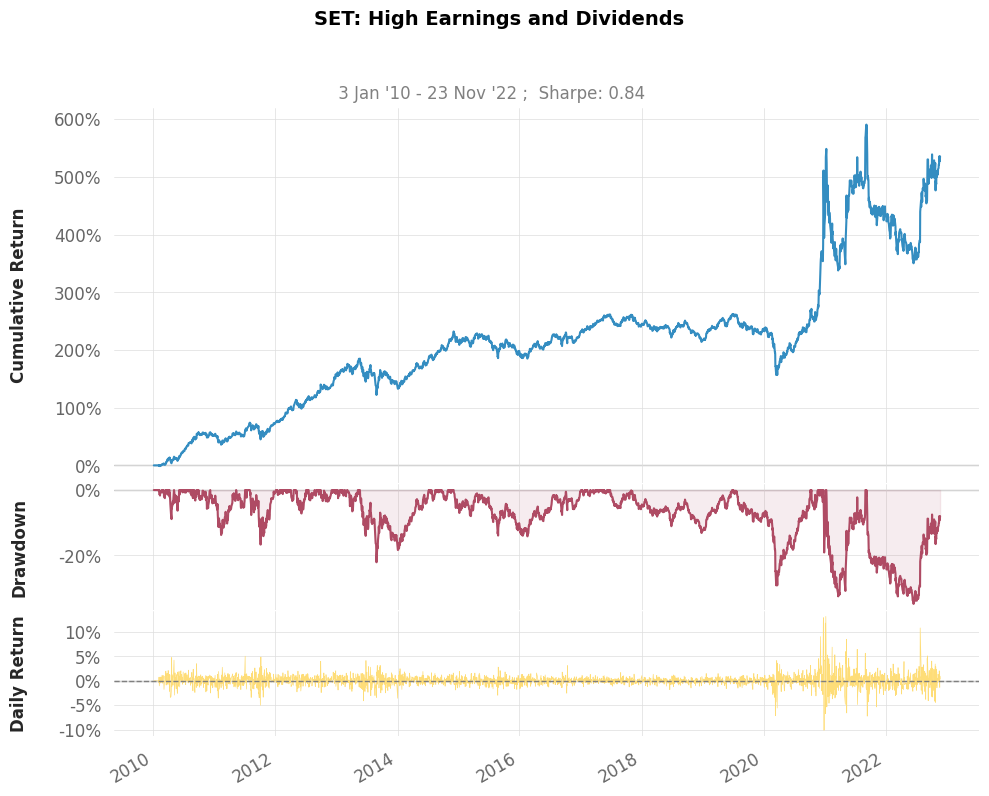

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   535.68%     121.83%
CAGR﹪              15.42%      6.37%

Sharpe              0.84        0.47
Prob. Sharpe Ratio  99.88%      95.09%
Sortino             1.31        0.65
Sortino/√2          0.92        0.46
Omega               1.19        1.19

Max Drawdown        -34.8%      -44.29%
Longest DD Days     762         1763

Gain/Pain Ratio     0.19        0.09
Gain/Pain (1M)      1.16        0.44

Payoff Ratio        1.03        0.91
Profit Factor       1.19        1.09
Common Sense Ratio  1.19        1.06
CPC Index           0.65        0.53
Tail Ratio          1.0         0.97
Outlier Win Ratio   4.04        4.72
Outlier Loss Ratio  4.03        4.3

MTD                 8.2%        0.97%
3M          

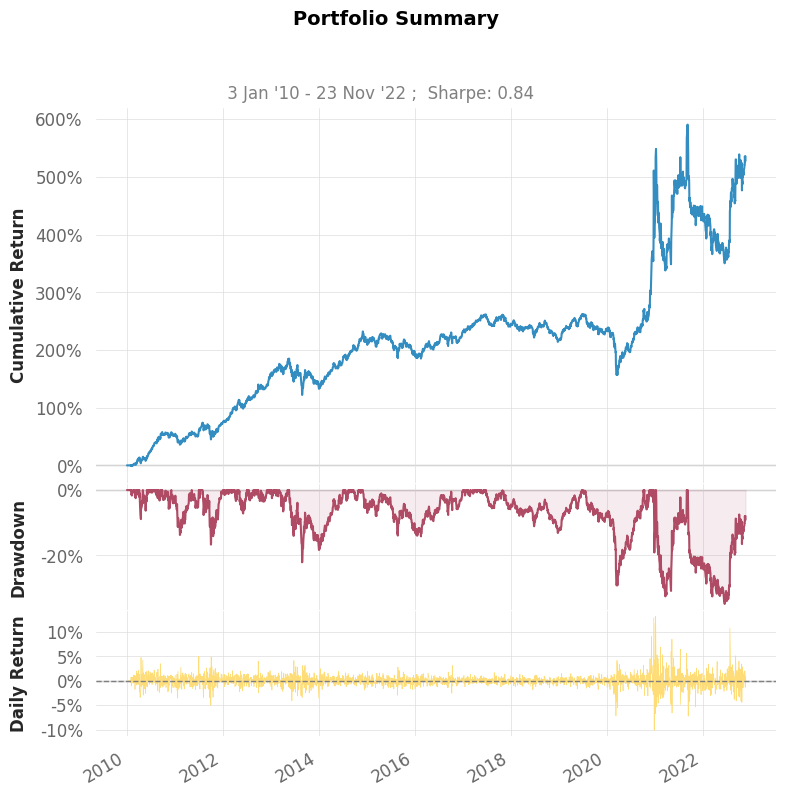

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


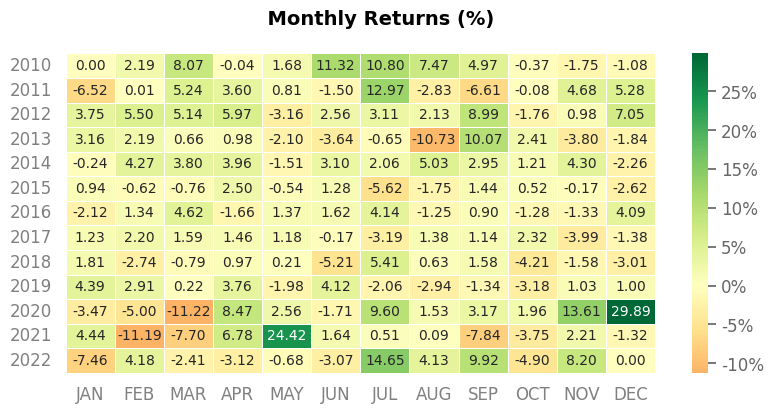

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# Solution 2

- Dividend(%) >= 3
- Dividend Continue 3 Years
- CFO 4 Quarter > 0 (net_operating)
- ROE Last 4 Q >= 10
- Net profit Growth QoQ 1 Quarter
- %Net profit Growth QoQY 1 Quarter
- Top 40 stock with the highest net profit QoQ 1Q

Ranking:  + Top 10 stock net profit QoQY 1Q + rebalance monthly

## Screening Condition

In [ ]:
# netprofit growth QoQ
net_proft_growth_qoq_df = (net_profit_df / net_profit_shift_df)
# netprofit growth QoQ
net_proft_growth_qoqy_df = (net_profit_df / net_profit_shift_4_df)

# screening condition
# dvd(%) > 3 and dvd continute 3 years
dvd_cond = dvd_yield_df > 3
dvd_continute_cond = (dvd_yield_df > 0) & (dvd_yield_y2_df > 0) & (dvd_yield_y3_df > 0)
# CFO 4q > 0
net_operation_cond = (net_operating_q1_df > 0) & (net_operating_q2_df > 0) & (net_operating_q3_df > 0) & (net_operating_q4_df > 0)
# roe last 4q >= 10
roe_cond = (roe_q1_df >= 10) & (roe_q2_df >= 10) & (roe_q3_df >= 10) & (roe_q4_df >= 10)
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = dvd_cond & dvd_continute_cond & net_operation_cond & roe_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

def screen_net_profit_growth_qoq(signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame) -> pd.DataFrame:
      return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )
      
def screen_net_profit_growth_qoqy(
    qoq_rank_df: pd.DataFrame, qoq_num: int, net_proft_growth_qoqy_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((qoq_rank_df <= qoq_num), net_proft_growth_qoqy_df, np.nan),
        columns=qoq_rank_df.columns,
        index=qoq_rank_df.index,
    )
# net profit growth(%QoQ) 1 quarter
# 40 highest net profit growth(%QoQ) 1 quarter
qoq_df = screen_net_profit_growth_qoq(signal_df, net_proft_growth_qoq_df)
qoq_rank_df = ssc.rank(
    factor_df=qoq_df, quantity=40, ascending=False
)  

# net profit growth(%QoQY) 1 quarter
# 20 highest net profit growth(%QoQY) 1 quarter
qoqy_df = screen_net_profit_growth_qoqy(qoq_rank_df=qoq_rank_df, qoq_num=10, net_proft_growth_qoqy_df=net_proft_growth_qoqy_df)
qoqy_rank_df = ssc.rank(
    factor_df=qoqy_df, quantity=20, ascending=False
)  

from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (qoqy_rank_df > 0) & (qoqy_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

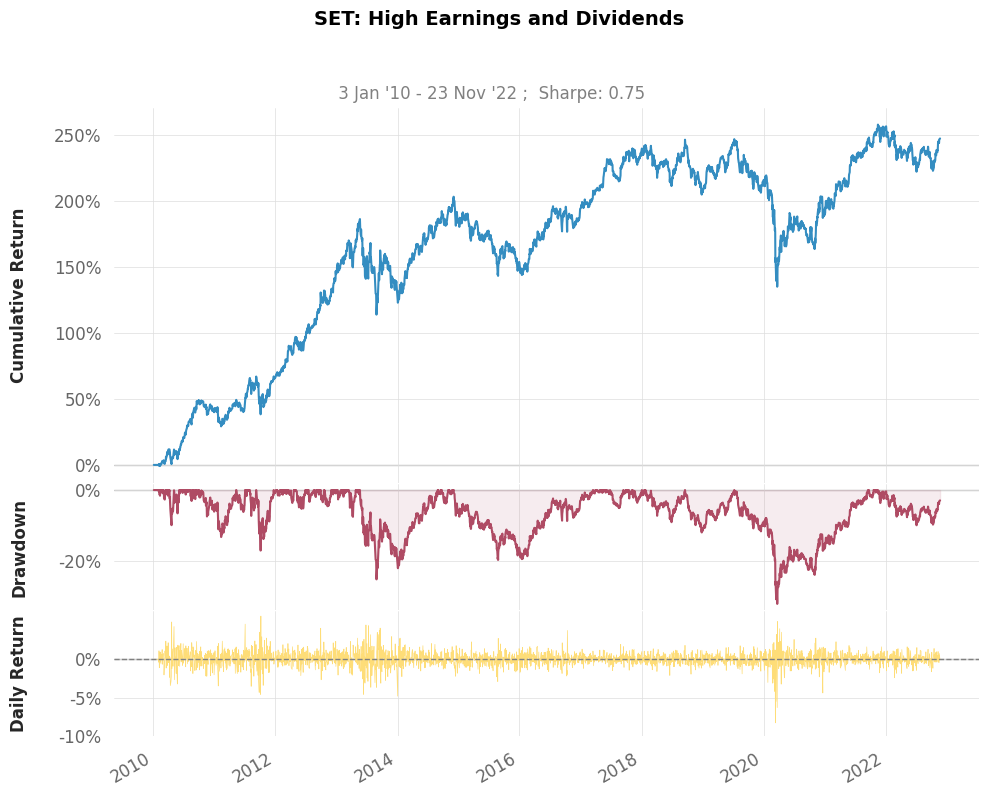

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   247.0%      121.83%
CAGR﹪              10.13%      6.37%

Sharpe              0.75        0.47
Prob. Sharpe Ratio  99.57%      95.09%
Sortino             1.07        0.65
Sortino/√2          0.76        0.46
Omega               1.14        1.14

Max Drawdown        -32.22%     -44.29%
Longest DD Days     833         1763

Gain/Pain Ratio     0.14        0.09
Gain/Pain (1M)      0.87        0.44

Payoff Ratio        1.0         0.92
Profit Factor       1.14        1.09
Common Sense Ratio  1.2         1.06
CPC Index           0.6         0.54
Tail Ratio          1.05        0.97
Outlier Win Ratio   3.66        3.61
Outlier Loss Ratio  4.28        3.82

MTD                 3.79%       0.97%
3M         

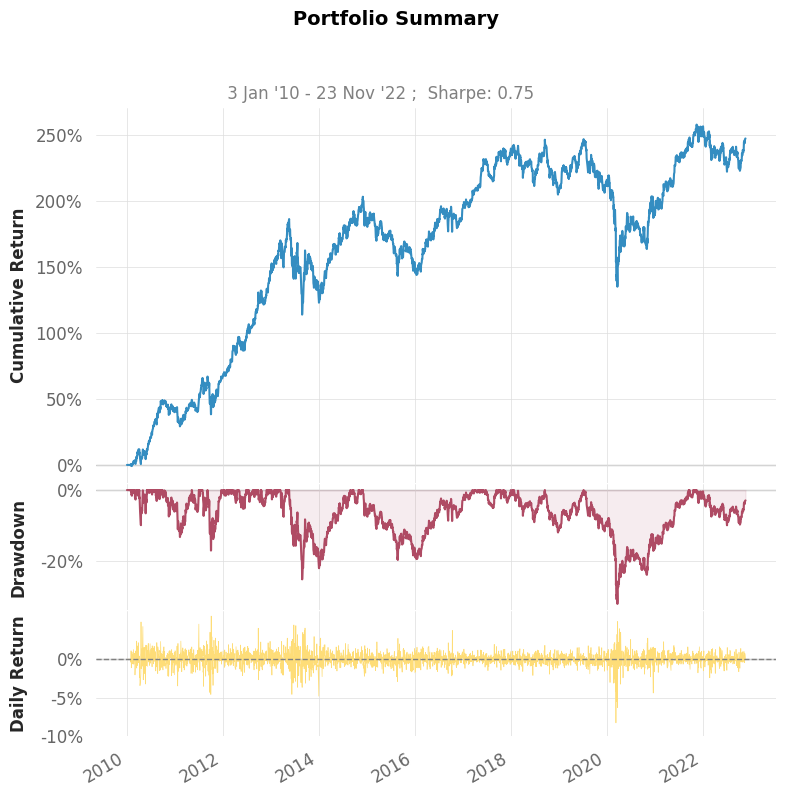

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


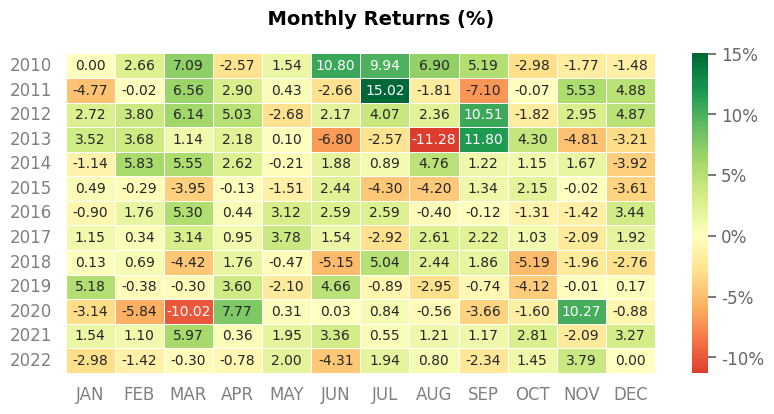

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

In [ ]:
UNIVERSE = ['SET100']
ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Solution 1

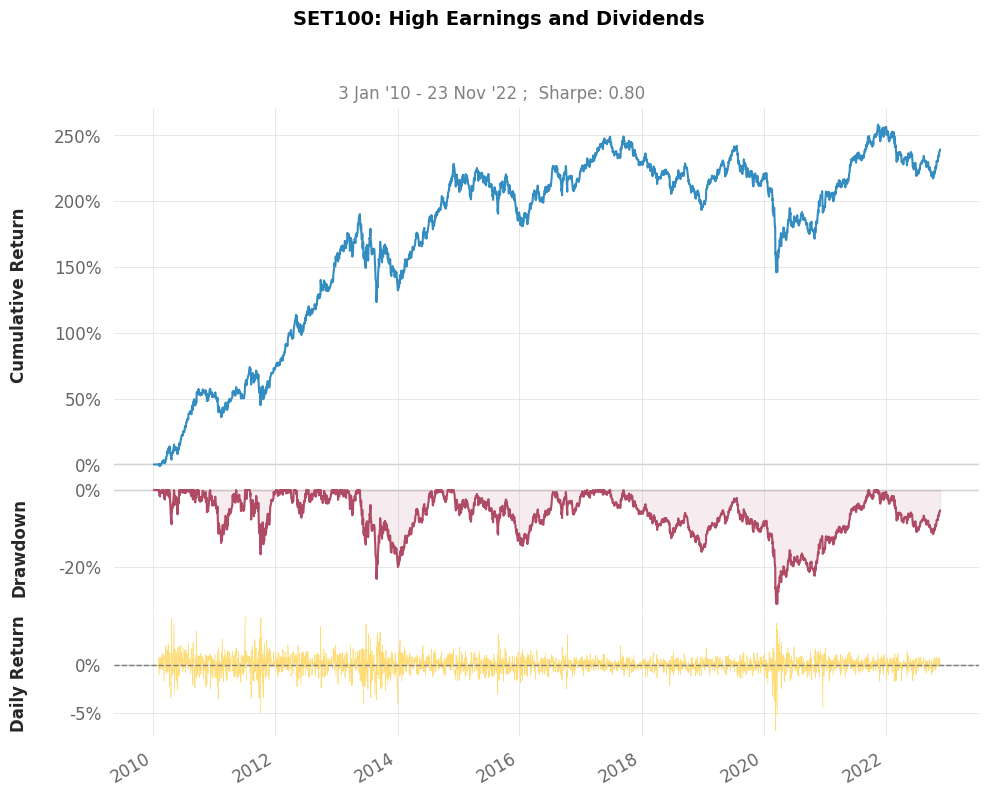

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   239.31%     121.83%
CAGR﹪              9.94%       6.37%

Sharpe              0.8         0.47
Prob. Sharpe Ratio  99.73%      95.09%
Sortino             1.14        0.65
Sortino/√2          0.8         0.46
Omega               1.15        1.15

Max Drawdown        -29.53%     -44.29%
Longest DD Days     1465        1763

Gain/Pain Ratio     0.15        0.09
Gain/Pain (1M)      0.92        0.44

Payoff Ratio        0.97        0.9
Profit Factor       1.15        1.09
Common Sense Ratio  1.19        1.06
CPC Index           0.6         0.53
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.84        3.4
Outlier Loss Ratio  4.35        3.62

MTD                 4.27%       0.97%
3M           

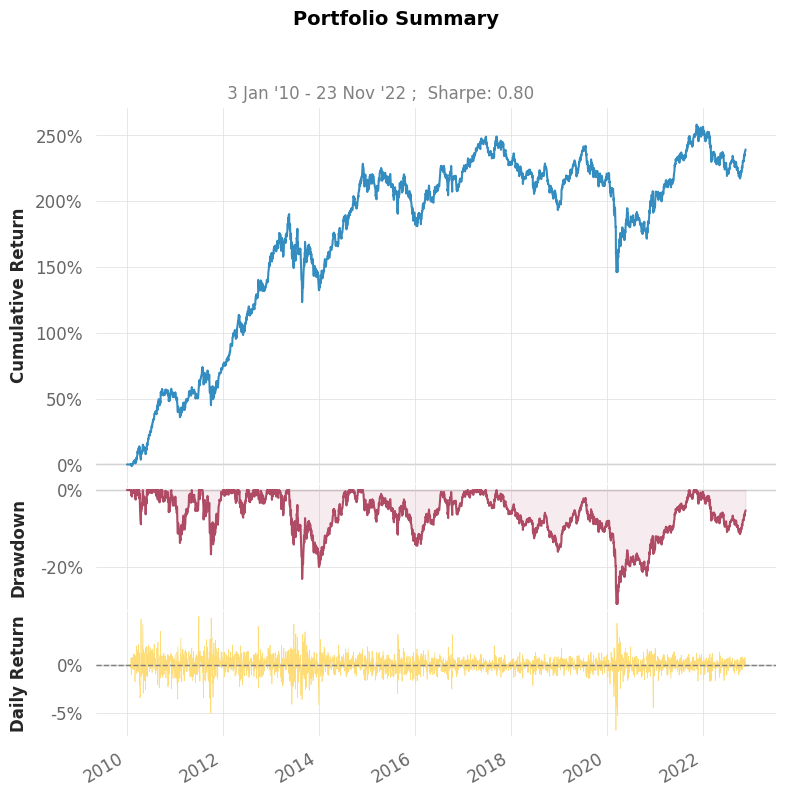

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


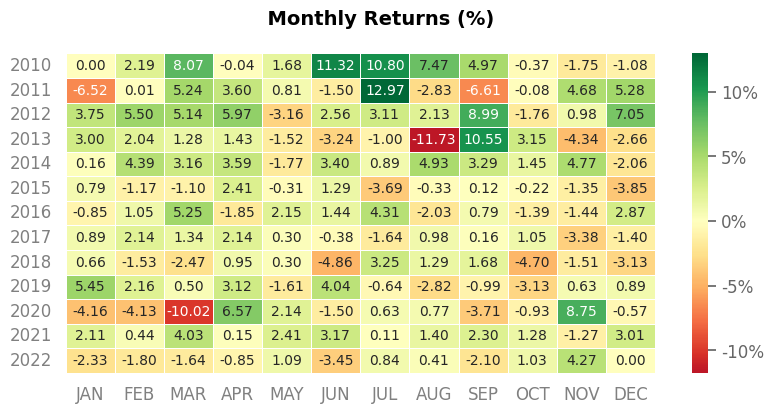

In [ ]:
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

# dvd(%) > 3 and dvd continute 3 years
dvd_yield_df = ssc.get_data(field="dvd_yield", timeframe='daily')
dvd_yield_y2_df = ssc.get_data("dvd_yield", "daily",shift=250)
dvd_yield_y3_df = ssc.get_data("dvd_yield", "daily",shift=500)

# CFO 4q > 0
net_operating_q1_df = ssc.get_data(field="net_operating", timeframe='quarterly')
net_operating_q2_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=1)
net_operating_q3_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=2)
net_operating_q4_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=3)

# roe last 4q >= 10
roe_q1_df = ssc.get_data(field="roe", timeframe='quarterly')
roe_q2_df = ssc.get_data(field="roe", timeframe='quarterly', shift=1)
roe_q3_df = ssc.get_data(field="roe", timeframe='quarterly', shift=2)
roe_q4_df = ssc.get_data(field="roe", timeframe='quarterly', shift=3)

# netprofit
net_profit_df =  ssc.get_data(field="net_profit", timeframe='quarterly')
# netprofit qoq
net_profit_shift_df =  ssc.get_data(field="net_profit", timeframe='quarterly', shift=1)
# netprofit qoqy
net_profit_shift_4_df =  ssc.get_data(field="net_profit", timeframe='quarterly', shift=4)

# netprofit growth QoQy
npg_qoqy_df = net_profit_df - net_profit_shift_4_df
# %netprofit growth QoQy
npg_percent_qoqy_df = (net_profit_df / net_profit_shift_4_df)
# screening condition
# dvd(%) > 3 and dvd continute 3 years
dvd_cond = dvd_yield_df > 3
dvd_continute_cond = (dvd_yield_df > 0) & (dvd_yield_y2_df > 0) & (dvd_yield_y3_df > 0)
# CFO 4q > 0
net_operation_cond = (net_operating_q1_df > 0) & (net_operating_q2_df > 0) & (net_operating_q3_df > 0) & (net_operating_q4_df > 0)
# roe last 4q >= 10
roe_cond = (roe_q1_df >= 10) & (roe_q2_df >= 10) & (roe_q3_df >= 10) & (roe_q4_df >= 10)
# netprofit growth QoQy
npg_qoqy_cond = npg_qoqy_df > 0
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = dvd_cond & dvd_continute_cond & net_operation_cond & roe_cond & npg_qoqy_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
def screen_npg_percent_qoqy_df(signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame) -> pd.DataFrame:
      return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )
# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)  
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

## Solution 2

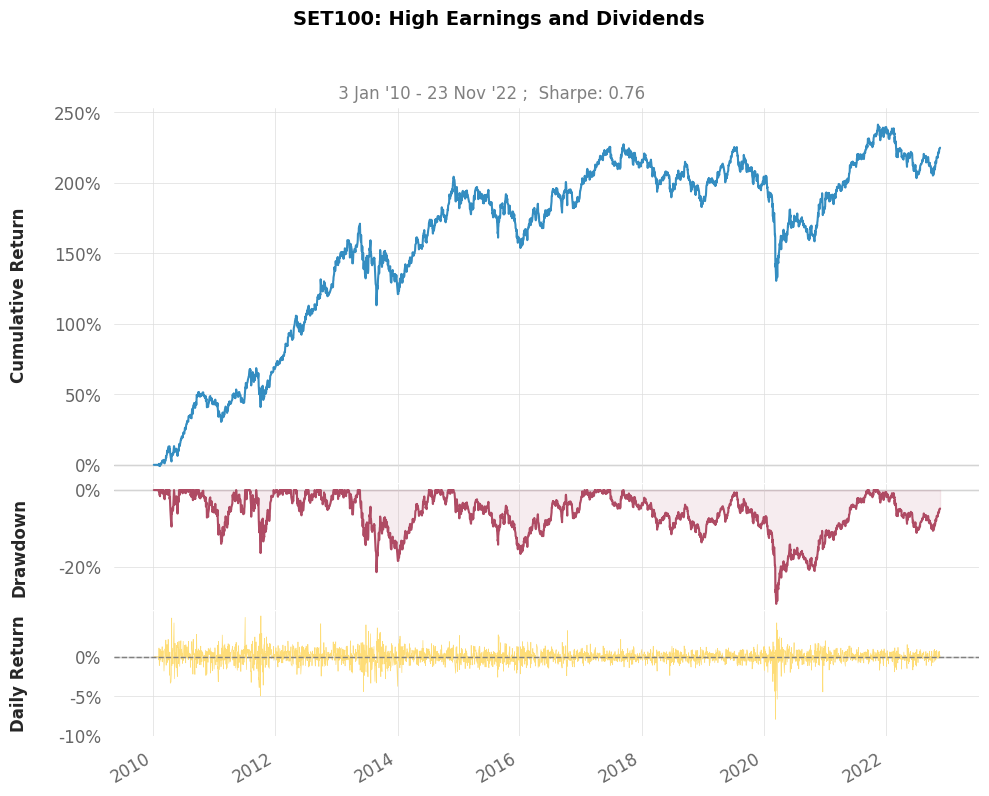

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   224.95%     121.83%
CAGR﹪              9.57%       6.37%

Sharpe              0.76        0.47
Prob. Sharpe Ratio  99.6%       95.09%
Sortino             1.08        0.65
Sortino/√2          0.76        0.46
Omega               1.15        1.15

Max Drawdown        -29.59%     -44.29%
Longest DD Days     1458        1763

Gain/Pain Ratio     0.15        0.09
Gain/Pain (1M)      0.88        0.44

Payoff Ratio        0.96        0.9
Profit Factor       1.15        1.09
Common Sense Ratio  1.22        1.06
CPC Index           0.59        0.53
Tail Ratio          1.06        0.97
Outlier Win Ratio   3.89        3.48
Outlier Loss Ratio  4.23        3.61

MTD                 3.44%       0.97%
3M          

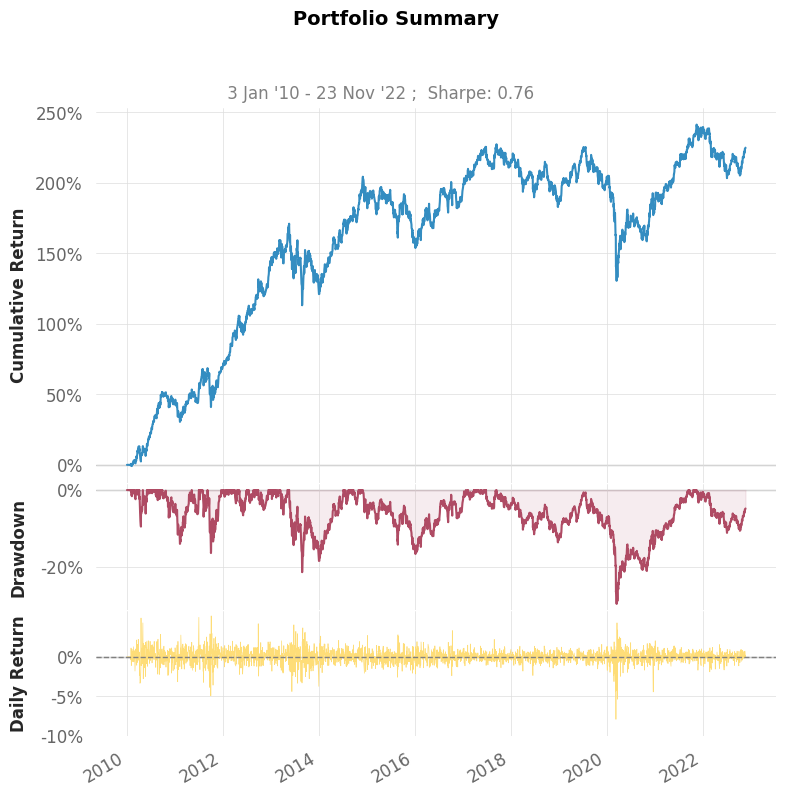

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


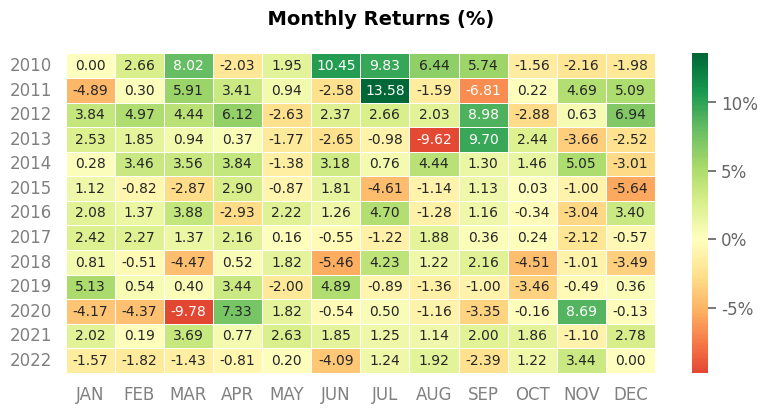

In [ ]:
# netprofit growth QoQ
net_proft_growth_qoq_df = (net_profit_df / net_profit_shift_df)
# netprofit growth QoQ
net_proft_growth_qoqy_df = (net_profit_df / net_profit_shift_4_df)

# screening condition
# dvd(%) > 3 and dvd continute 3 years
dvd_cond = dvd_yield_df > 3
dvd_continute_cond = (dvd_yield_df > 0) & (dvd_yield_y2_df > 0) & (dvd_yield_y3_df > 0)
# CFO 4q > 0
net_operation_cond = (net_operating_q1_df > 0) & (net_operating_q2_df > 0) & (net_operating_q3_df > 0) & (net_operating_q4_df > 0)
# roe last 4q >= 10
roe_cond = (roe_q1_df >= 10) & (roe_q2_df >= 10) & (roe_q3_df >= 10) & (roe_q4_df >= 10)
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = dvd_cond & dvd_continute_cond & net_operation_cond & roe_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

def screen_net_profit_growth_qoq(signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame) -> pd.DataFrame:
      return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )
      
def screen_net_profit_growth_qoqy(
    qoq_rank_df: pd.DataFrame, qoq_num: int, net_proft_growth_qoqy_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((qoq_rank_df <= qoq_num), net_proft_growth_qoqy_df, np.nan),
        columns=qoq_rank_df.columns,
        index=qoq_rank_df.index,
    )
# net profit growth(%QoQ) 1 quarter
# 40 highest net profit growth(%QoQ) 1 quarter
qoq_df = screen_net_profit_growth_qoq(signal_df, net_proft_growth_qoq_df)
qoq_rank_df = ssc.rank(
    factor_df=qoq_df, quantity=40, ascending=False
)  

# net profit growth(%QoQY) 1 quarter
# 20 highest net profit growth(%QoQY) 1 quarter
qoqy_df = screen_net_profit_growth_qoqy(qoq_rank_df=qoq_rank_df, qoq_num=10, net_proft_growth_qoqy_df=net_proft_growth_qoqy_df)
qoqy_rank_df = ssc.rank(
    factor_df=qoqy_df, quantity=20, ascending=False
)  

from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (qoqy_rank_df > 0) & (qoqy_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])



# SET50

In [ ]:
UNIVERSE = ['SET50']
ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Solution 1

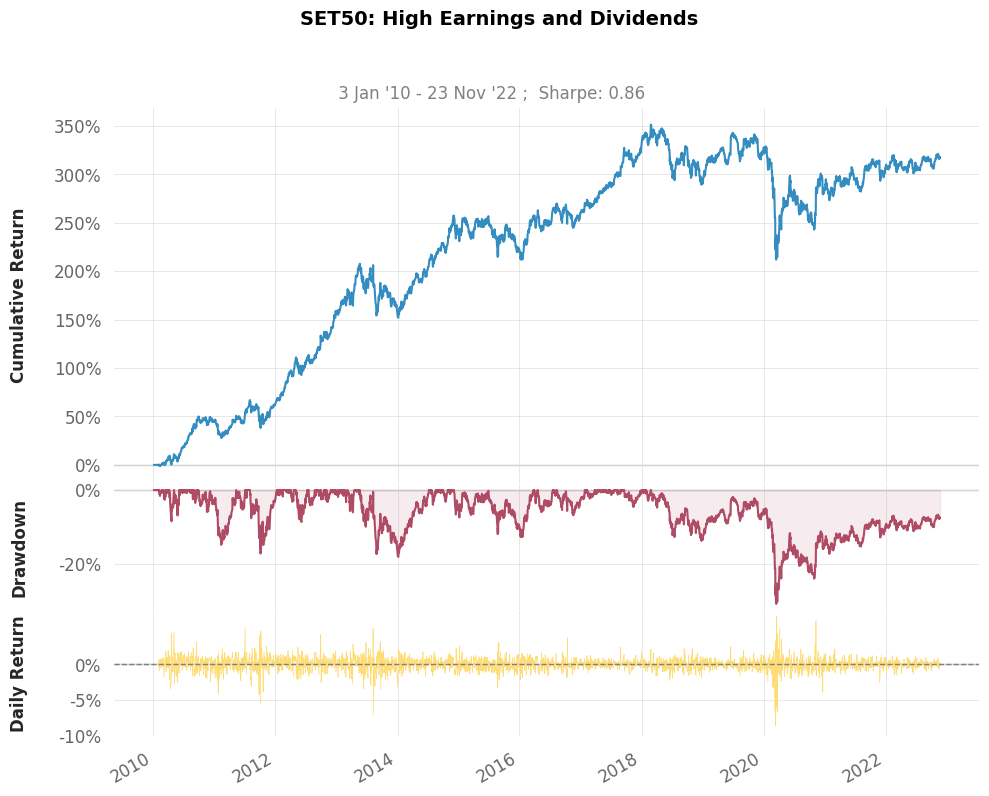

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   317.7%      121.83%
CAGR﹪              11.73%      6.37%

Sharpe              0.86        0.47
Prob. Sharpe Ratio  99.86%      95.09%
Sortino             1.23        0.65
Sortino/√2          0.87        0.46
Omega               1.17        1.17

Max Drawdown        -30.88%     -44.29%
Longest DD Days     1730        1763

Gain/Pain Ratio     0.17        0.09
Gain/Pain (1M)      1.02        0.44

Payoff Ratio        0.98        0.92
Profit Factor       1.17        1.09
Common Sense Ratio  1.21        1.06
CPC Index           0.62        0.54
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.75        3.55
Outlier Loss Ratio  4.03        3.58

MTD                 0.09%       0.97%
3M         

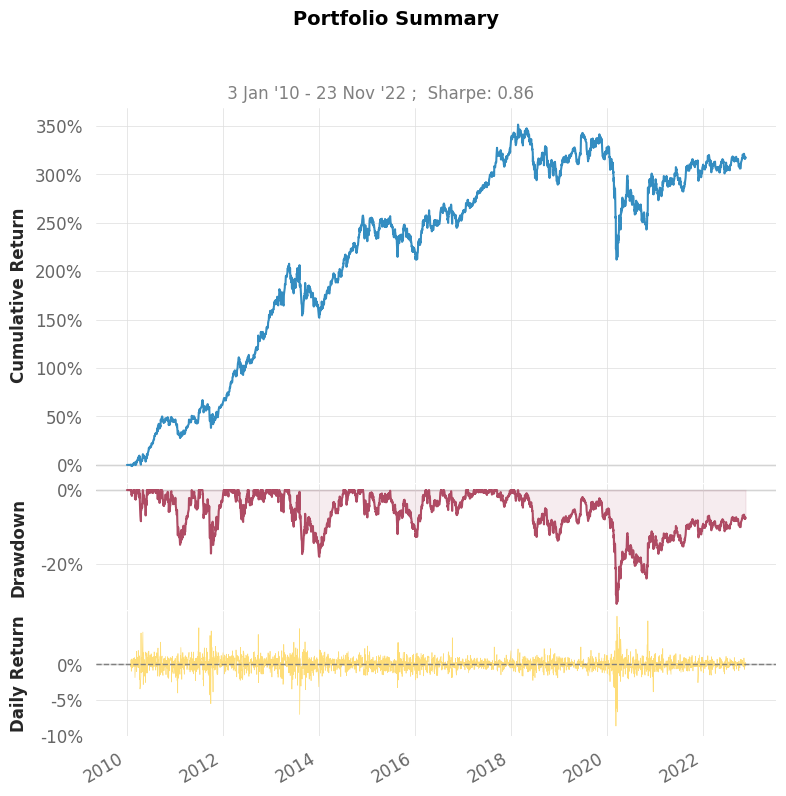

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


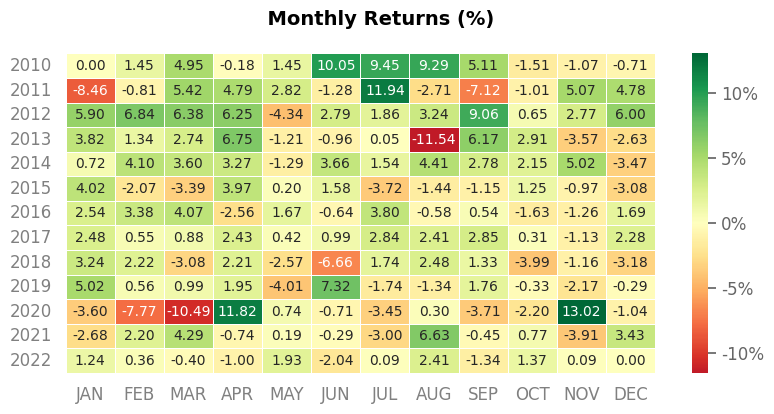

In [ ]:
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

# dvd(%) > 3 and dvd continute 3 years
dvd_yield_df = ssc.get_data(field="dvd_yield", timeframe='daily')
dvd_yield_y2_df = ssc.get_data("dvd_yield", "daily",shift=250)
dvd_yield_y3_df = ssc.get_data("dvd_yield", "daily",shift=500)

# CFO 4q > 0
net_operating_q1_df = ssc.get_data(field="net_operating", timeframe='quarterly')
net_operating_q2_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=1)
net_operating_q3_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=2)
net_operating_q4_df = ssc.get_data(field="net_operating", timeframe='quarterly', shift=3)

# roe last 4q >= 10
roe_q1_df = ssc.get_data(field="roe", timeframe='quarterly')
roe_q2_df = ssc.get_data(field="roe", timeframe='quarterly', shift=1)
roe_q3_df = ssc.get_data(field="roe", timeframe='quarterly', shift=2)
roe_q4_df = ssc.get_data(field="roe", timeframe='quarterly', shift=3)

# netprofit
net_profit_df =  ssc.get_data(field="net_profit", timeframe='quarterly')
# netprofit qoq
net_profit_shift_df =  ssc.get_data(field="net_profit", timeframe='quarterly', shift=1)
# netprofit qoqy
net_profit_shift_4_df =  ssc.get_data(field="net_profit", timeframe='quarterly', shift=4)

# netprofit growth QoQy
npg_qoqy_df = net_profit_df - net_profit_shift_4_df
# %netprofit growth QoQy
npg_percent_qoqy_df = (net_profit_df / net_profit_shift_4_df)
# screening condition
# dvd(%) > 3 and dvd continute 3 years
dvd_cond = dvd_yield_df > 3
dvd_continute_cond = (dvd_yield_df > 0) & (dvd_yield_y2_df > 0) & (dvd_yield_y3_df > 0)
# CFO 4q > 0
net_operation_cond = (net_operating_q1_df > 0) & (net_operating_q2_df > 0) & (net_operating_q3_df > 0) & (net_operating_q4_df > 0)
# roe last 4q >= 10
roe_cond = (roe_q1_df >= 10) & (roe_q2_df >= 10) & (roe_q3_df >= 10) & (roe_q4_df >= 10)
# netprofit growth QoQy
npg_qoqy_cond = npg_qoqy_df > 0
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = dvd_cond & dvd_continute_cond & net_operation_cond & roe_cond & npg_qoqy_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
def screen_npg_percent_qoqy_df(signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame) -> pd.DataFrame:
      return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )
# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)  
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

## Solution 2

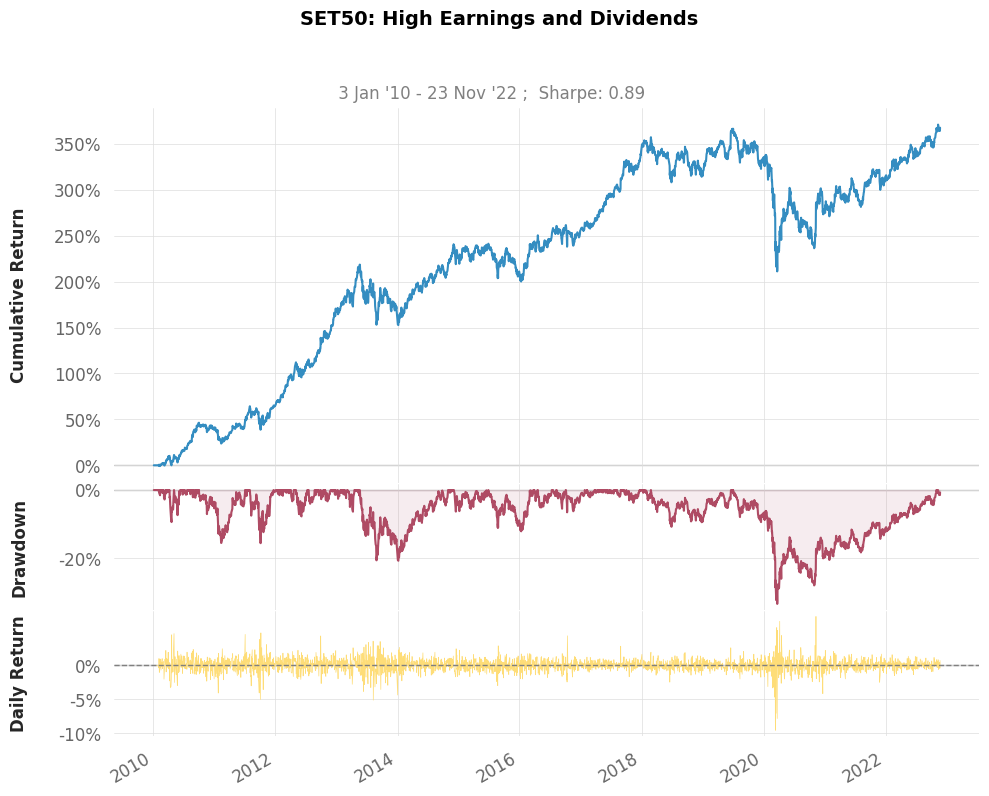

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   367.66%     121.83%
CAGR﹪              12.71%      6.37%

Sharpe              0.89        0.47
Prob. Sharpe Ratio  99.91%      95.09%
Sortino             1.29        0.65
Sortino/√2          0.91        0.46
Omega               1.18        1.18

Max Drawdown        -33.3%      -44.29%
Longest DD Days     1216        1763

Gain/Pain Ratio     0.18        0.09
Gain/Pain (1M)      1.08        0.44

Payoff Ratio        1.0         0.92
Profit Factor       1.18        1.09
Common Sense Ratio  1.24        1.06
CPC Index           0.63        0.54
Tail Ratio          1.05        0.97
Outlier Win Ratio   3.76        3.74
Outlier Loss Ratio  4.12        3.74

MTD                 1.06%       0.97%
3M         

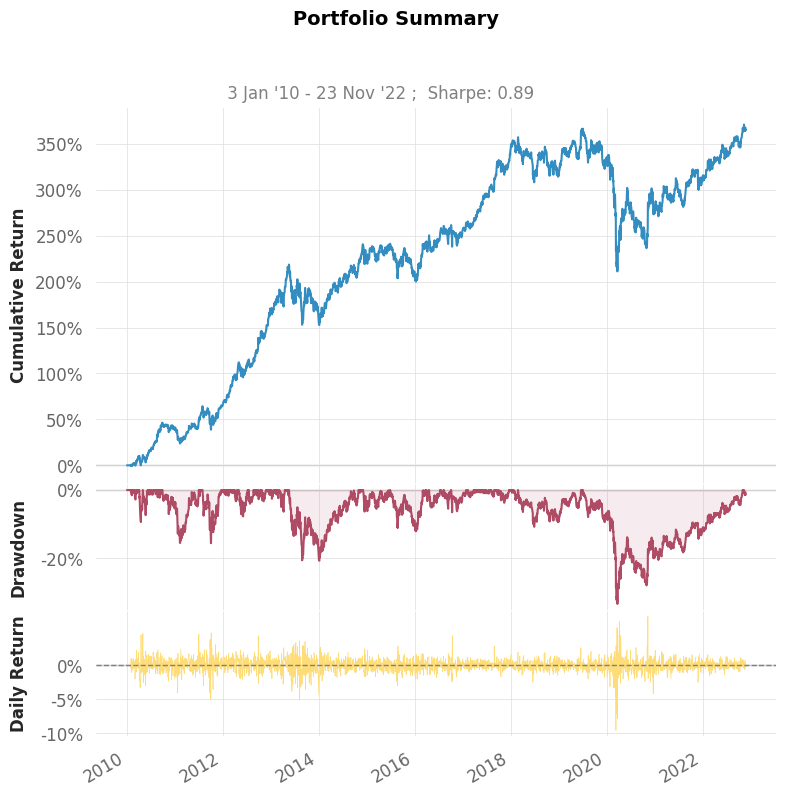

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


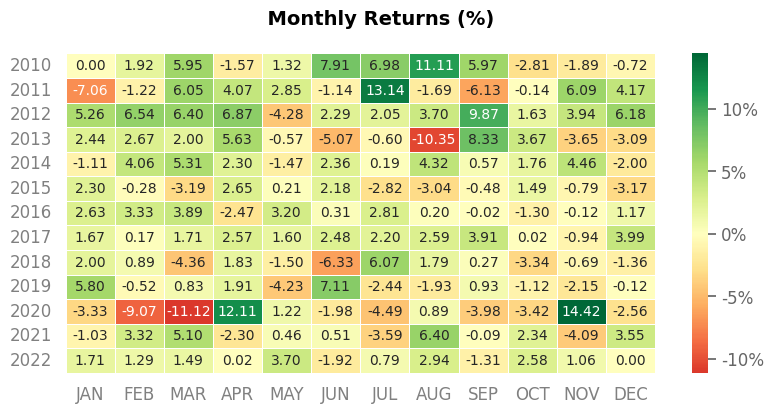

In [ ]:
# netprofit growth QoQ
net_proft_growth_qoq_df = (net_profit_df / net_profit_shift_df)
# netprofit growth QoQ
net_proft_growth_qoqy_df = (net_profit_df / net_profit_shift_4_df)

# screening condition
# dvd(%) > 3 and dvd continute 3 years
dvd_cond = dvd_yield_df > 3
dvd_continute_cond = (dvd_yield_df > 0) & (dvd_yield_y2_df > 0) & (dvd_yield_y3_df > 0)
# CFO 4q > 0
net_operation_cond = (net_operating_q1_df > 0) & (net_operating_q2_df > 0) & (net_operating_q3_df > 0) & (net_operating_q4_df > 0)
# roe last 4q >= 10
roe_cond = (roe_q1_df >= 10) & (roe_q2_df >= 10) & (roe_q3_df >= 10) & (roe_q4_df >= 10)
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = dvd_cond & dvd_continute_cond & net_operation_cond & roe_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

def screen_net_profit_growth_qoq(signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame) -> pd.DataFrame:
      return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )
      
def screen_net_profit_growth_qoqy(
    qoq_rank_df: pd.DataFrame, qoq_num: int, net_proft_growth_qoqy_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((qoq_rank_df <= qoq_num), net_proft_growth_qoqy_df, np.nan),
        columns=qoq_rank_df.columns,
        index=qoq_rank_df.index,
    )
# net profit growth(%QoQ) 1 quarter
# 40 highest net profit growth(%QoQ) 1 quarter
qoq_df = screen_net_profit_growth_qoq(signal_df, net_proft_growth_qoq_df)
qoq_rank_df = ssc.rank(
    factor_df=qoq_df, quantity=40, ascending=False
)  

# net profit growth(%QoQY) 1 quarter
# 20 highest net profit growth(%QoQY) 1 quarter
qoqy_df = screen_net_profit_growth_qoqy(qoq_rank_df=qoq_rank_df, qoq_num=10, net_proft_growth_qoqy_df=net_proft_growth_qoqy_df)
qoqy_rank_df = ssc.rank(
    factor_df=qoqy_df, quantity=20, ascending=False
)  

from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (qoqy_rank_df > 0) & (qoqy_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

